In [1]:
import numpy as np
from sif.kernels import SquaredExponentialKernel, MaternKernel
from sif.models import GaussianProcessClassifier
from sif.samplers import EllipticalSliceSampler

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Create random data with an arbitrary latent function which determines the probability of each class.

In [3]:
X = np.random.normal(size=(100, 1))
X_pred = np.atleast_2d(np.linspace(-5., 5., num=500)).T

In [4]:
k1, k2 = 4., 10.
f = k1 * np.sin(k2 * X).ravel()
pi = 1. / (1. + np.exp(-f))
y = np.random.binomial(1, pi)

Create a log-likelihood function for the Gaussian process classifier. We approximate the marginal likelihood using a Laplace approximation.

In [5]:
def log_likelihood_func(f):
    gpc = GaussianProcessClassifier(SquaredExponentialKernel(np.exp(f[:1]), np.exp(f[-1])))
    gpc.fit(X, y)
    return gpc.log_likelihood

Visualize the posterior class probabilities using an elliptical slice sampler to infer the distribution of the kernel hyperparameters.

In [6]:
n_samples = 1000
mean = np.zeros((2, ))
covariance = np.diag(np.ones((2, )) * 5.)

In [7]:
sampler = EllipticalSliceSampler(mean, covariance, log_likelihood_func)
samples = np.exp(sampler.sample(n_samples))

In [8]:
func_samples = np.zeros((n_samples, X_pred.shape[0]))
for i in range(n_samples):
    gpc = GaussianProcessClassifier(MaternKernel(samples[i, :1], samples[i, -1]))
    gpc.fit(X, y)
    func_samples[i] = gpc.sample(X_pred)

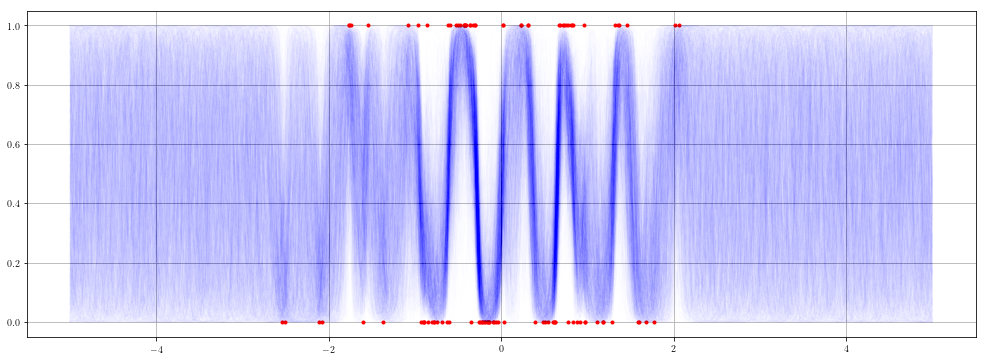

In [9]:
plt.figure(figsize=(17, 6))
plt.plot(X.ravel(), y, "r.")
for i in range(min(1000, n_samples)):
    plt.plot(X_pred.ravel(), func_samples[i], "b-", alpha=1. / 200)
plt.grid()
plt.show()

/Users/jamesbrofos/miniconda3/envs/sif-devel/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


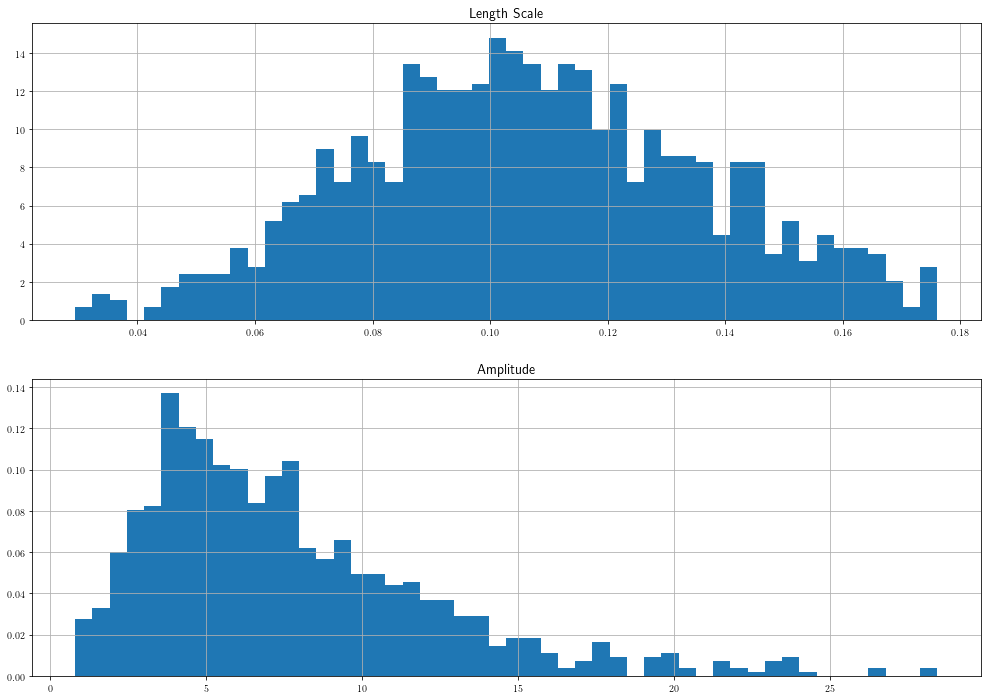

In [10]:
f, axes = plt.subplots(2, figsize=(17, 12))
for i, ax in enumerate(axes):
    S = samples[:, i]
    S = S[S < np.percentile(S, 99.)]
    ax.hist(S, bins=50, normed=True)
    ax.grid()
    ax.set_title(["Length Scale", "Amplitude"][i], fontsize=14)
plt.show()